In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs, lang2large_family

figure_dir = "fig/typology"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load data

In [2]:
exps = pd.read_table("../dataframes/bert_exps.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

exps = add_probing_location_better_column(exps)

In [3]:
exps

,model,language,task,perturbation,probing_location,dev_acc,test_acc,tag,pos,full_task,family,probing_location_better
0,mBERT,Afrikaans,number_noun,B$_2$,first,0.848571,0.819286,number,noun,Afrikaans number_noun,Germanic,False
1,mBERT,Afrikaans,number_noun,B$_2$,last,0.983571,0.952143,number,noun,Afrikaans number_noun,Germanic,True
2,mBERT,Afrikaans,number_noun,L$_2$,first,0.892143,0.860000,number,noun,Afrikaans number_noun,Germanic,False
3,mBERT,Afrikaans,number_noun,L$_2$,last,0.975714,0.949286,number,noun,Afrikaans number_noun,Germanic,True
4,mBERT,Afrikaans,number_noun,R$_2$,first,0.887857,0.829286,number,noun,Afrikaans number_noun,Germanic,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5227,mBERT,Urdu,number_noun,permute,first,0.863571,0.855714,number,noun,Urdu number_noun,Indic,False
5228,mBERT,Urdu,number_noun,permute,last,0.937143,0.917857,number,noun,Urdu number_noun,Indic,True
5229,mBERT,Urdu,number_noun,prev1,last,0.925000,0.885714,number,noun,Urdu number_noun,Indic,True
5230,mBERT,Urdu,number_noun,NaN,first,0.917857,0.838571,number,noun,Urdu number_noun,Indic,False


In [4]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

ValueError: Merging with fertility dataframe changed the number of rows: 5232 --> 5104

# Perturbations

In [4]:
data_perturbations = ['TARG','L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [
    'prev1',
    'next1',
    'mBERT-rand-subw',
]
baseline_models = []

# Test effect

$$
\text{Effect}(p, t) = 100(1 - \frac{\text{Acc}(p, t)}{\text{Acc}(t)})
$$

In [5]:
bert_exps = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better==True)
]

bert_exps.shape

(2943, 12)

In [6]:
bert_exps.groupby(['language', 'task', 'perturbation'], dropna=False).size().value_counts()

1    2943
dtype: int64

In [7]:
unperturbed = bert_exps[bert_exps.perturbation.isnull()]
unperturbed = unperturbed.set_index(['language', 'task']).test_acc

In [8]:
perturbed = bert_exps[bert_exps.perturbation.isin(model_perturbations + data_perturbations)].pivot_table(
    index=['language', 'task'], columns='perturbation', values='test_acc'
)

In [9]:
test_effect = 100 * (1 - perturbed / unperturbed.values[:, None])

In [10]:
test_effect.mean()

perturbation
B$_2$               3.899276
L$_2$               1.680163
R$_2$               1.120250
TARG               17.517343
mBERT-rand-subw    19.895513
next1              12.587702
permute             5.367234
prev1               8.488408
dtype: float64

# Linguistic typology

## Logistic regression (classification) using WALS features

In [11]:
areas = pd.read_csv("../dataframes/wals/wals_areas.tsv", sep="\t")
feat2area = dict(areas[['Name', 'Area']].drop_duplicates().values)
feat2area['Family'] = 'Family'

wals_languages = []
wals = []
param2area = {}
for fn in os.listdir('../dataframes/wals'):
    if not fn.endswith('csv'):
        continue
    lang = fn.split(".")[0]
    wals_languages.append(lang)
    df = pd.read_csv(f"../dataframes/wals/{lang}.csv", encoding='latin1')
    df = df.sort_values('Parameter').pivot(index='Language', columns='Parameter', values='Name')
    wals.append(df)
    
wals = pd.concat(wals, sort=True)
wals.index = wals_languages
wals.loc['Latin'] = np.nan 
wals['Family'] = wals.index.map(lambda l: lang2family[l])
print(wals.shape), wals.isnull().stack().mean()

(39, 177)


/tmp/ipykernel_8168/722615636.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  wals['Family'] = wals.index.map(lambda l: lang2family[l])


(None, 0.4632768361581921)

In [12]:
te = test_effect[model_perturbations + data_perturbations].copy()
te['HAS_TASK'] = 1
logreg_perts = te.columns
te = te.unstack()
te = te.fillna(0)
te['HAS_TASK'] = te['HAS_TASK'].fillna(0)

In [13]:
lin_acc = []
K = 3

for col in wals.columns:
    target = wals[col].dropna()
    common = sorted(set(target.index) & set(te.index))
    label_cnt = target.value_counts()
    large_classes = label_cnt[label_cnt>=K]
    if len(large_classes) < 2:
        continue
    target = target[target.isin(large_classes.index)]
    if target.value_counts(normalize=True).max() > 0.8:
         continue
    if len(label_cnt) < 2:
        continue
    te_common = te.loc[target.index]
    for pert in logreg_perts:
        X = te_common[pert]
        if (len(label_cnt) == 2):
            slver = 'liblinear'
        else:
            slver = 'newton-cg'
        score = cross_val_score(
            #RandomForestClassifier(max_depth=2, random_state=0),
            LogisticRegression(solver=slver, multi_class='auto', max_iter=200),
            X, target, cv=3, scoring='f1_macro')
        notnull = len(target)
        lin_acc.append({
            'perturbation': pert, 'feature': col, 'score': score.mean(),
            'notnull': notnull, 'labels': dict(target.value_counts())})
    X = te_common
    score = cross_val_score(
        LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
        X, target, cv=3, scoring='f1_macro')
    notnull = len(target)
    lin_acc.append({'perturbation': 'ALL', 'feature': col, 'score': score.mean(),
                    'notnull': notnull, 'labels': dict(target.value_counts())})
lin_acc = pd.DataFrame(lin_acc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [14]:
pd.set_option('display.max_rows', 500)
l = lin_acc.sort_values('score', ascending=False).copy()

In [15]:
l.perturbation = l.perturbation.str.replace('$', '')
l['Area'] = l.feature.apply(lambda l: feat2area[l])
l.head(15)

/tmp/ipykernel_8168/2209059831.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  l.perturbation = l.perturbation.str.replace('$', '')


,perturbation,feature,score,notnull,labels,Area
739,ALL,Systems of Gender Assignment,0.933333,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
502,mBERT-rand-subw,Position of Interrogative Phrases in Content Q...,0.916667,26,"{'Initial interrogative phrase': 18, 'Not init...",Word Order
339,ALL,Order of Adposition and Noun Phrase,0.915789,36,"{'Prepositions': 28, 'Postpositions': 8}",Word Order
509,ALL,Position of Interrogative Phrases in Content Q...,0.914885,26,"{'Initial interrogative phrase': 18, 'Not init...",Word Order
909,ALL,Family,0.901190,27,"{'Slavic': 9, 'Germanic': 8, 'Romance': 7, 'Ur...",Family
116,B_2,Distributive Numerals,0.895238,19,"{'Marked by preceding word': 11, 'No distribut...",Nominal Categories
117,permute,Distributive Numerals,0.895238,19,"{'Marked by preceding word': 11, 'No distribut...",Nominal Categories
503,TARG,Position of Interrogative Phrases in Content Q...,0.892663,26,"{'Initial interrogative phrase': 18, 'Not init...",Word Order
732,mBERT-rand-subw,Systems of Gender Assignment,0.866667,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
589,ALL,Reciprocal Constructions,0.853968,15,"{'Mixed': 9, 'Distinct from reflexive': 6}",Simple Clauses


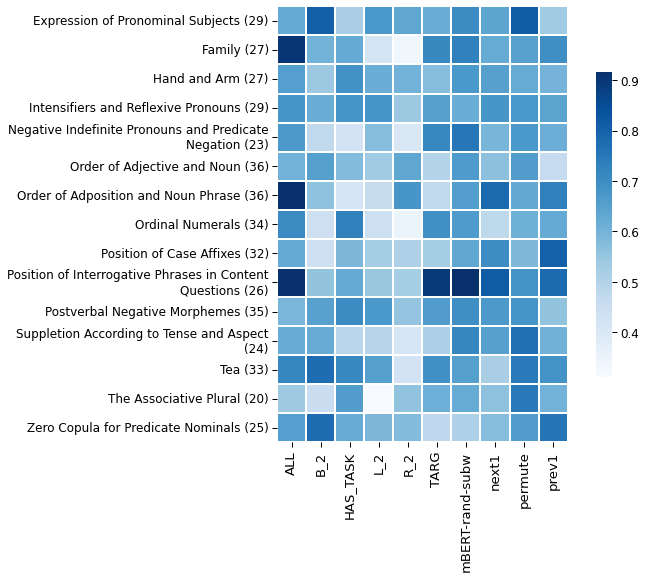

In [16]:
features = set(l[l['notnull']>=20].groupby('feature').score.mean().sort_values(ascending=False).head(15).index)

def wrap_text(text, maxline=40):
    lines = []
    this_line = []
    for word in text.split(" "):
        this_line.append(word)
        if sum(len(w) + 1 for w in this_line) - 1 >= maxline:
            lines.append(" ".join(this_line))
            this_line = []
    if this_line:
        lines.append(" ".join(this_line))
    return "\n".join(lines)
        
def plot_wals_pert_heatmap(data, save_fn=None, title=None):
    notnull = data[['feature', 'notnull']].drop_duplicates().set_index('feature')['notnull']
    table = data.pivot(index='feature', columns='perturbation', values='score')
    ysize = max(len(table), 6)
    max_text_len = data['feature'].str.len().max()
    scale = 'small' if max_text_len >= 85 else 'large'
    with matplotlib.rc_context(rc={'ytick.labelsize': 'large'}):
        fig, ax = plt.subplots(1, figsize=(12, 8))
        sns.heatmap(table, cmap='Blues', ax=ax, linewidth=.1, square=True, cbar_kws={'shrink': 0.7})
        ticks = []
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            t = "{} ({})".format(t, notnull.loc[t])
            tick.set_text(wrap_text(t))
            ticks.append(tick)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.subplots_adjust(left=0.5)
        plt.tight_layout()
        if title:
            ax.set_title(title)
        if save_fn:
            fig.savefig(save_fn)
plot_wals_pert_heatmap(l[l.feature.isin(features)], save_fn=f"{figure_dir}/heatmap_wals_logreg.png")

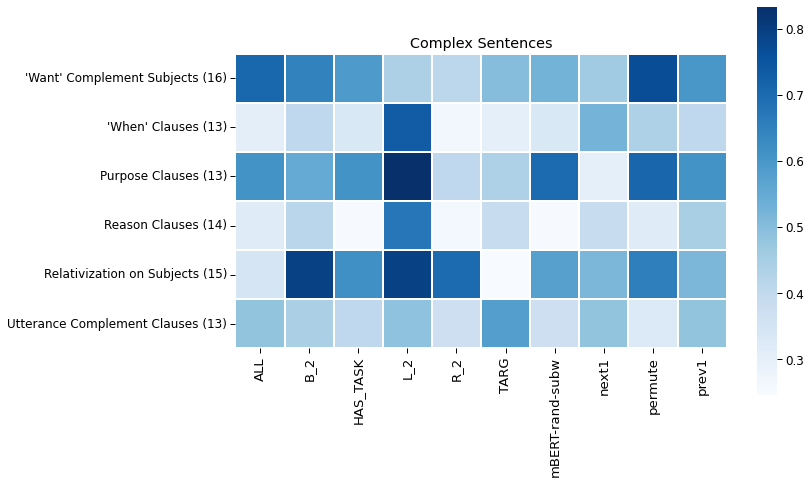

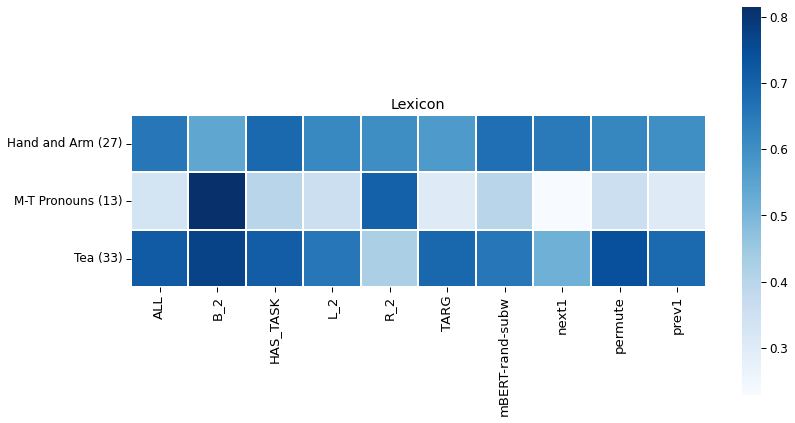

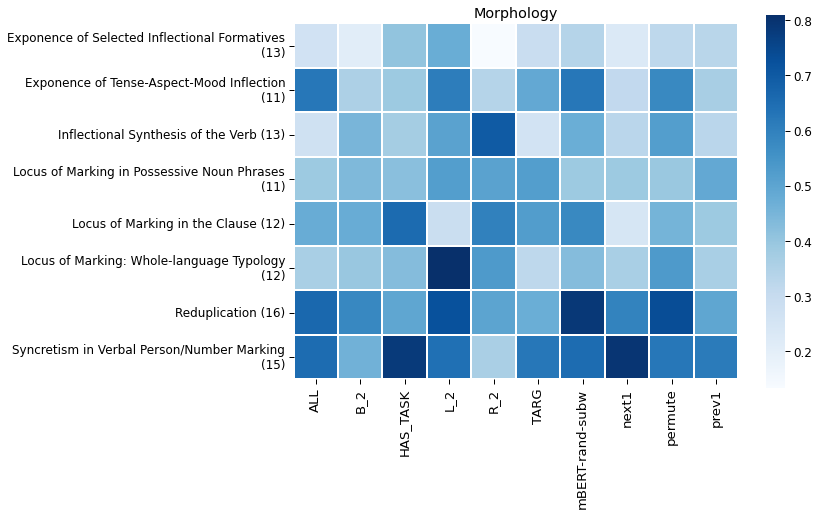

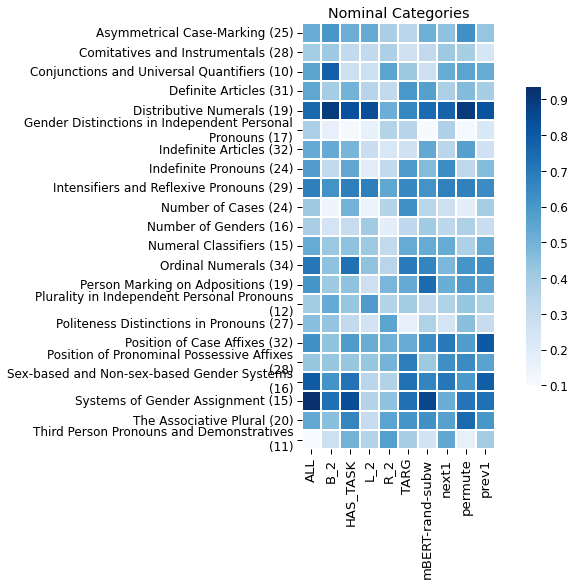

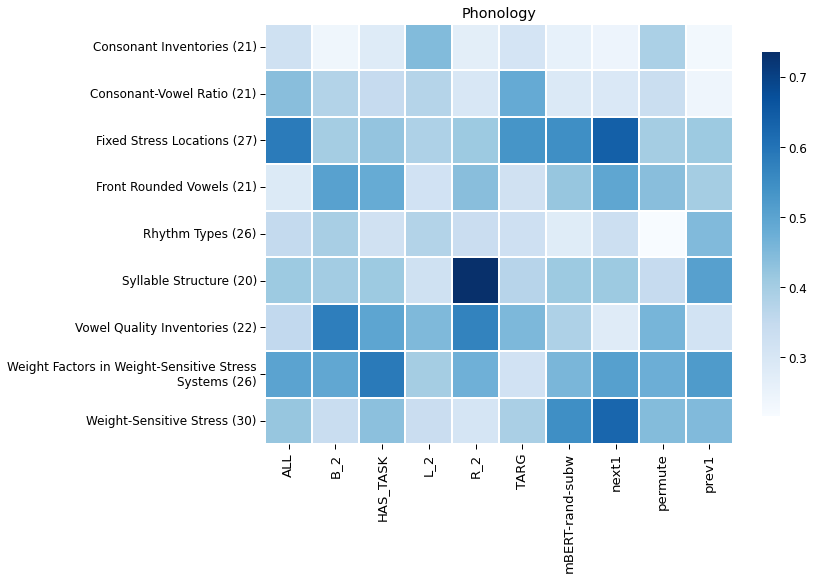

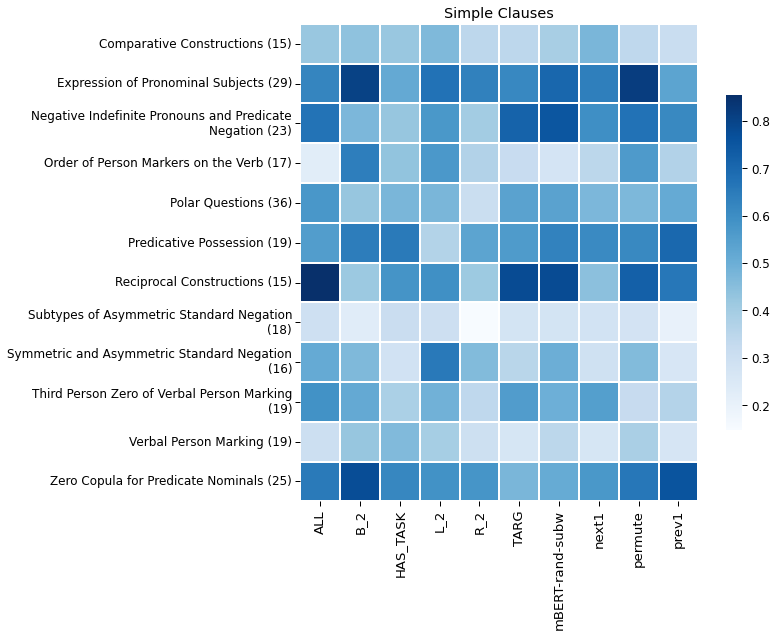

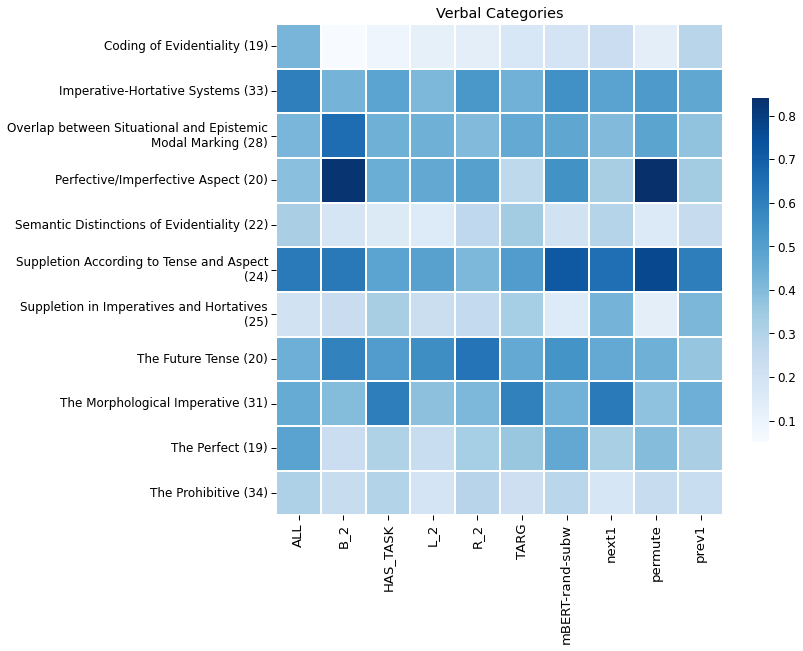

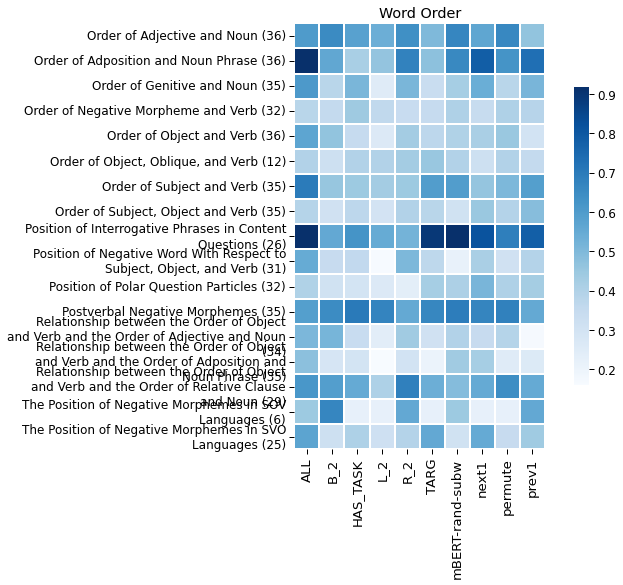

In [17]:
for area, group in l.groupby('Area'):
    if group.feature.nunique() < 2:
        continue
    area_name = area.replace(' ', '_').lower()
    plot_wals_pert_heatmap(group, title=area, save_fn=f"{figure_dir}/heatmap_wals_{area_name}.png")

## Linear regression weights

Target: effect of each perturbations

In [18]:
lin_acc = []
K = 3

linreg_scores = []

for pert in model_perturbations + data_perturbations:
    target = test_effect[pert].mean(level=0)
    target = target.drop('Latin')
    features = pd.get_dummies(wals.drop('Latin').fillna('Nan'))
    score = cross_val_score(
        SVR(),
        features, target, cv=3, scoring='neg_root_mean_squared_error')
    linreg_scores.append({'perturbation': pert, 'score': score.mean()})
linreg_scores = pd.DataFrame(linreg_scores)

/tmp/ipykernel_8168/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_8168/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_8168/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
/tmp/ipykernel_8168/3970028662.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecat

In [19]:
linreg_scores

,perturbation,score
0,prev1,-2.920841
1,next1,-4.368867
2,mBERT-rand-subw,-5.203874
3,TARG,-7.927509
4,L$_2$,-1.347578
5,R$_2$,-2.374257
6,B$_2$,-3.914581
7,permute,-5.065792


## Family aggregated mean/std

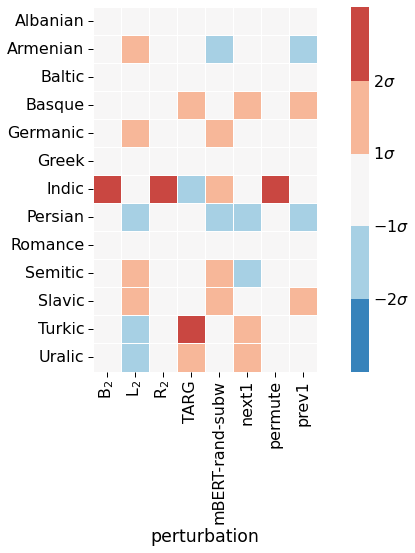

In [20]:
te = test_effect.reset_index()
te['family'] = te.language.apply(lambda l: lang2family[l])
te = te.groupby('family').mean()
te_std = te.std()
te_mean = te.mean()

te_discrete = pd.cut(((te - te_mean) / te_std).stack(), bins=[-1000, -2, -1, 1, 2, 1000], labels=[-2, -1, 0, 1, 2]).unstack().astype(int)
te_discrete
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    sns.heatmap(te_discrete, ax=ax, cmap=sns.color_palette('RdBu_r', 5),
                linewidths=.5, vmin=-2, vmax=2, center=0, square=True)
    ax.set_ylabel("")
    colorbar = ax.collections[0].colorbar
    #colorbar.ax.set_frame_on(True)
    colorbar.ax.tick_params(size=0)
    ticklabels = [
        "$-2\sigma$",
        "$-1\sigma$",
        "$1\sigma$",
        "$2\sigma$",
    ]
    u = 2 / 2.5
    colorbar.set_ticks([-1.5*u, -0.5*u, 0.5*u, 1.5*u])
    colorbar.set_ticklabels(ticklabels)
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/heatmap_family_effect_std_bin.pdf", bbox_inches='tight')

## Clustering

In [25]:
def do_cluster(K):
    #d = unfiltered['test_effect'][keep_perturbations]
    X = test_effect.pivot_table(index='language', columns='task')
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K, n_init=5)
    k.fit(X)
    clusters = [[] for _ in range(K)]
    for i, lab in enumerate(k.labels_):
        clusters[lab].append(X.index[i])
    print(f"K = {K}")
    print("\n------\n".join(", ".join(cl) for cl in clusters))
    
do_cluster(5)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


K = 5
Croatian, Czech, German, Slovenian
------
Arabic, Bulgarian, Latin, Polish, Russian, Serbian, Slovak, Ukrainian
------
Afrikaans, Albanian, Armenian, Basque, Catalan, Danish, Dutch, English, French, Greek, Hebrew, Italian, Latvian, Lithuanian, Norwegian_Bokmal, Norwegian_Nynorsk, Persian, Portuguese, Romanian, Spanish, Swedish, Turkish
------
Estonian, Finnish, Hungarian
------
Hindi, Urdu


In [34]:
cooc = defaultdict(lambda: defaultdict(int))

def increase_cooc(langs):
    for l1 in langs:
        for l2 in langs:
            cooc[l1][l2] += 1
            
for _ in range(100):
    K = np.random.randint(3, 9)
    X = test_effect.pivot_table(index='language', columns='task')[model_perturbations + data_perturbations]
    X = X.fillna(X.mean())
    k = KMeans(n_clusters=K)
    k.fit(X)
    cl = pd.DataFrame({'language': X.index, 'cluster':k.labels_})
    cl.groupby('cluster').language.apply(increase_cooc)

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/developer/

In [35]:
l = exps[['family', 'language']].drop_duplicates().sort_values(['family', 'language'])
l['code'] = l.language.apply(lambda l: lang2code[l])

In [36]:
e = exps[['language']].drop_duplicates()
e['family'] = e['language'].apply(lambda l: lang2large_family[l])
family_size = e.family.value_counts().sort_index()

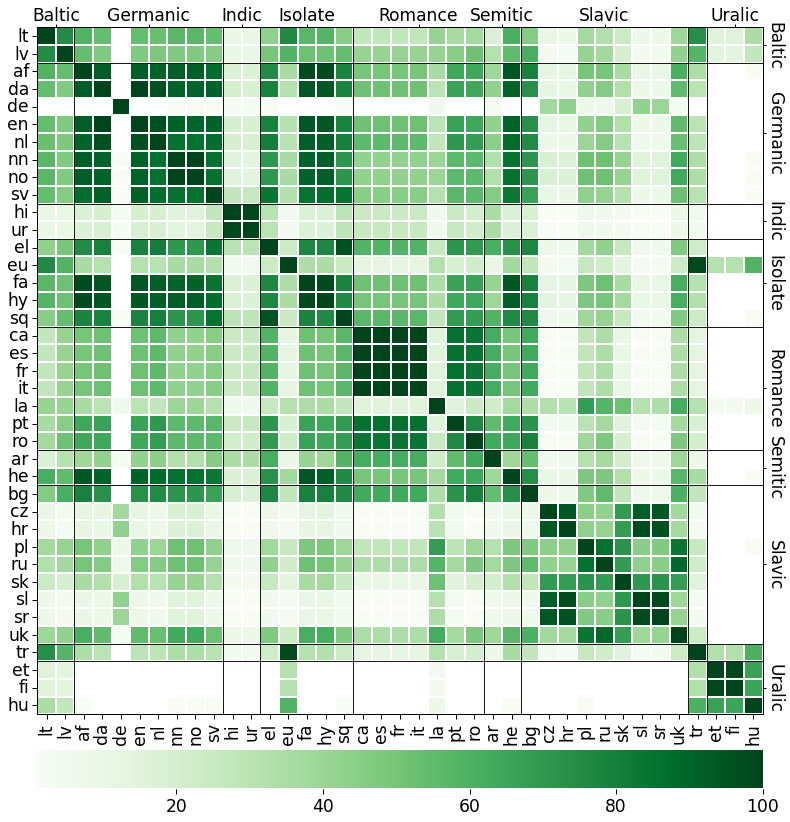

In [37]:
ticklabels = []
ticklocs = []
lang_family = exps[['language']].drop_duplicates()
lang_family['family'] = lang_family['language'].apply(lambda l: lang2large_family[l])
lang_family['code'] = lang_family['language'].apply(lambda l: lang2code[l])
family_size = lang_family.family.value_counts().sort_index()

for fi, (family, size) in enumerate(family_size.items()):
    if size > 1:
        ticklabels.append(family)
        start = family_size.iloc[:fi].sum()
        if fi < len(e) - 1:
            end = family_size.iloc[:fi+1].sum()
        else:
            end = family_size.sum()
        loc = (start+end) / 2
        ticklocs.append(loc)
        
lang_order = lang_family.sort_values(['family', 'code'])

with sns.plotting_context('paper', font_scale=1.95):
    grid_kws = {"height_ratios": (.9, .05), "hspace": .1}

    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(13, 14))
    data = pd.DataFrame(cooc).loc[lang_order.language][lang_order.language]
    data.columns = [lang2code[c] for c in data.columns]
    data.index = [lang2code[c] for c in data.index]
    sns.heatmap(data, ax=ax, cmap='Greens', cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, linewidths=.1)
    for f in np.cumsum(family_size)[:-1]:
        ax.plot((f, f), (0, data.shape[0]), c='black', linewidth=.9)
        ax.plot((0, data.shape[1]), (f, f), c='black', linewidth=.9)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax2 = ax.twiny()
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(ticklabels)
    ax2.tick_params(axis='x', which='major', pad=0, length=3)
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(ax.get_xlim())
    
    ax3 = ax.twinx()
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(ticklabels, va='center')
    ax3.tick_params(axis='y', rotation=-90, which='major', pad=0, length=3)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylim(ax.get_ylim())
    
    fig.savefig(f"{figure_dir}/heatmap_langlang_cluster_cooc.pdf")

In [104]:
from openTSNE import TSNE
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.rcsetup import cycler
from os.path import abspath, dirname, join
import numpy as np
import scipy.sparse as sp

In [136]:
def plot(x, y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 100)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        # default_colors = matplotlib.rcParams["axes.prop_cycle"]
        default_colors = cycler(color=['#808080', '#556b2f', '#a0522d', '#006400', '#8b0000', '#808000', '#483d8b', '#3cb371',
                                        '#008080', '#4682b4', '#000080', '#32cd32', '#daa520', '#800080', '#b03060', '#ff0000',
                                        '#00ced1', '#ff8c00', '#ffff00', '#00ff00', '#00fa9a', '#dc143c', '#00bfff', '#0000ff',
                                        '#a020f0', '#f08080', '#adff2f', '#ff7f50', '#ff00ff', '#1e90ff', '#f0e68c', '#dda0dd',
                                        '#add8e6', '#7b68ee', '#ee82ee', '#7fffd4', '#ff69b4',  '#ffe4c4', '#ffc0cb'])
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        #ax.scatter(
        #    centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        #)

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 1.0,
                    label,
                    fontsize=kwargs.get("fontsize", 10),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [141]:
test_effect.groupby(column=['language']).mean()

TypeError: groupby() got an unexpected keyword argument 'column'

In [67]:
X = test_effect.groupby('language').mean().to_numpy()
y_lang = test_effect.index.get_level_values('language').drop_duplicates().to_numpy()
y_family = test_effect.index.get_level_values('language').drop_duplicates().to_numpy()
for i, a in enumerate(y_family):
    y_family[i] = lang2family[a]

In [62]:
tsne = TSNE(
    perplexity=5,
    metric="chebyshev",
    n_jobs=100,
    random_state=42,
    verbose=False,
)

In [63]:
embedding_train = tsne.fit(X)

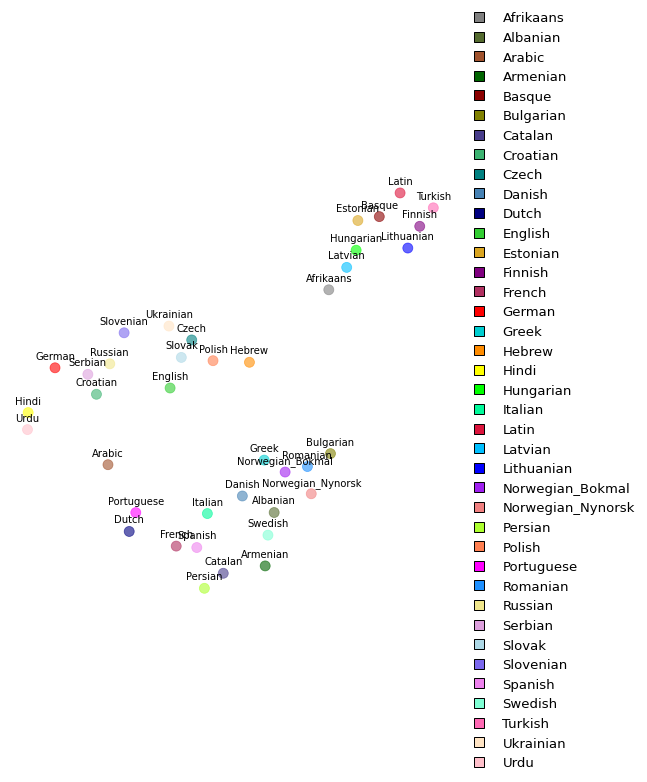

In [137]:
plot(embedding_train, y_lang, draw_centers=True, draw_cluster_labels=True)

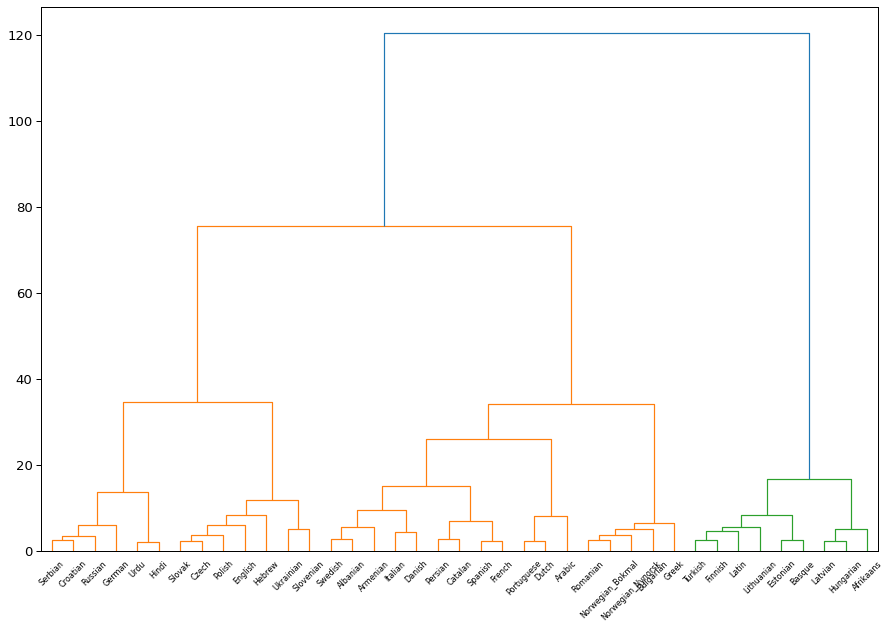

In [121]:
linked = linkage(embedding_train, 'ward')

labelList = y_lang

plt.figure(figsize=(15, 10))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()